# IP Adapters
paper link: https://arxiv.org/pdf/2308.06721

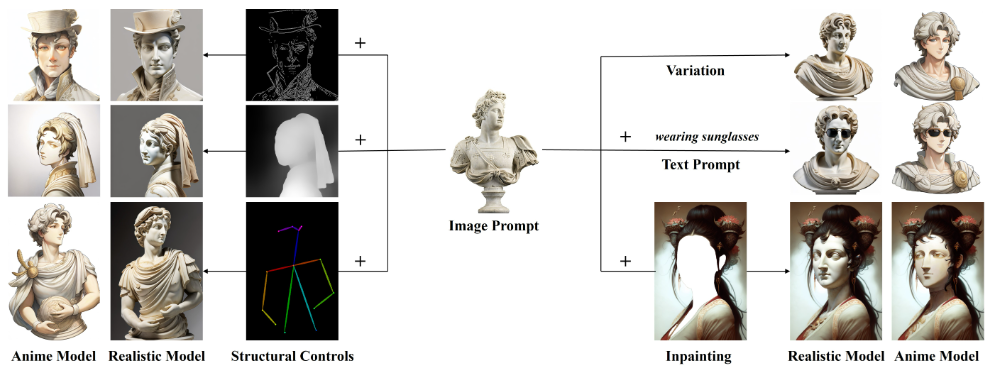


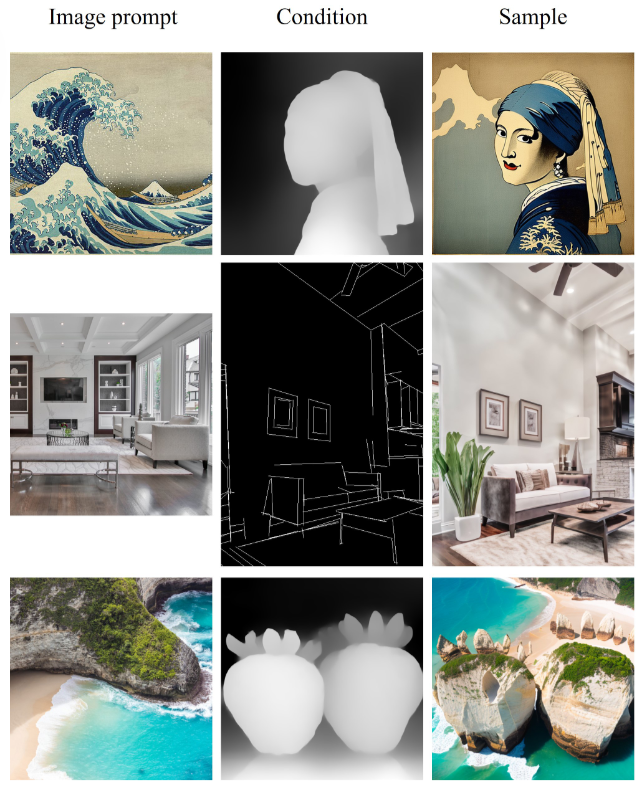


IP-Adapter is a lightweight module that enables pretrained text-to-image diffusion models to incorporate image prompts by adding a decoupled cross-attention mechanism that processes text and image features separately.


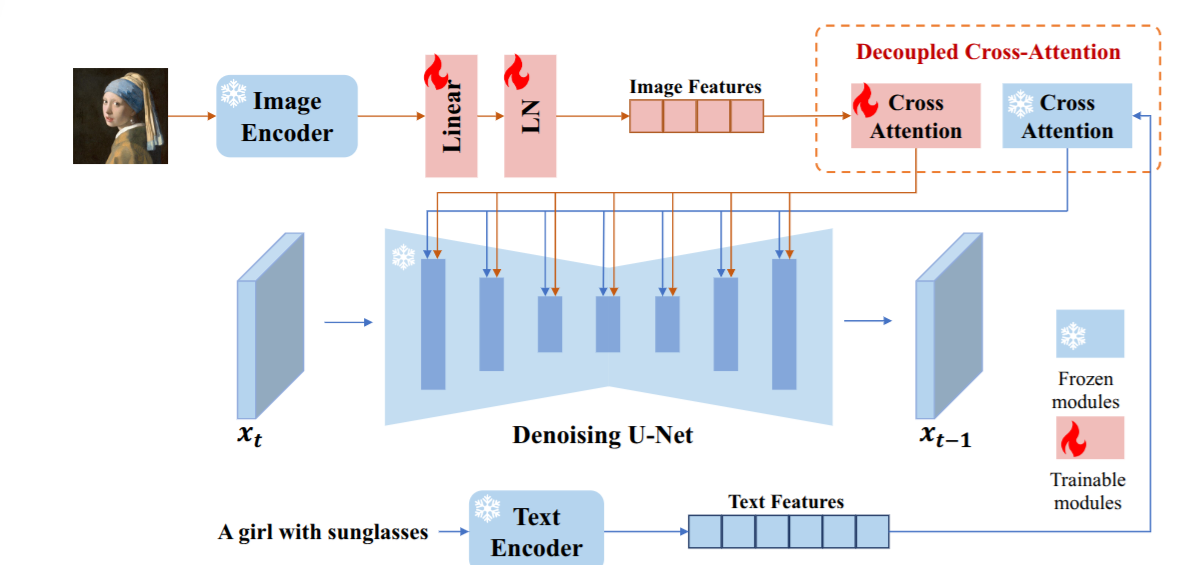

In [1]:
import numpy as np
import torch
from pathlib import Path
from diffusers.utils import load_image
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from diffusers import StableDiffusionPipeline,DPMSolverMultistepScheduler,DDIMScheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Load Controlnet

In [2]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

controlnet =  ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16)

model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'
pipeline = StableDiffusionControlNetPipeline.from_pretrained(model_id,
                                                             controlnet = controlnet,
                                                             safety_checker=None, 
                                                             torch_dtype=torch.float16).to(device)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
# Controlnet depth processor
import transformers
depth_estimator = transformers.pipeline('depth-estimation',model="xingyang1/Distill-Any-Depth-Small-hf")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


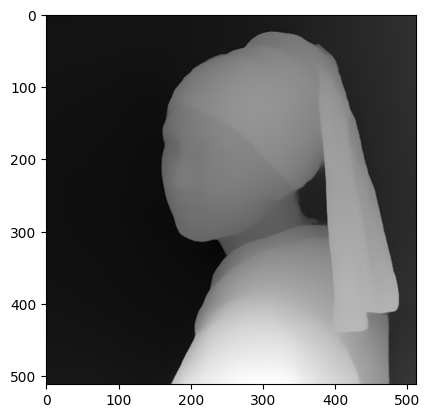

In [4]:
image = load_image("vermeer.jpg")
depth = depth_estimator(image)["depth"]
depth = np.array(depth)
depth = depth[:, :, None]
depth = np.concatenate([depth,depth,depth], axis=2)
depth = Image.fromarray(depth)

plt.imshow(depth)
plt.show()

# Load IP adapter

In [9]:
pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder='models', 
  weight_name="ip-adapter_sd15.bin"
)

# Generate Image Variations (prompt = '')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

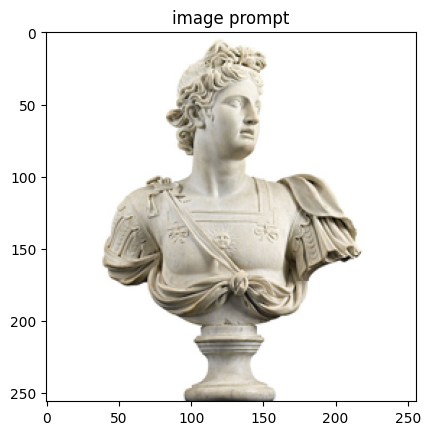

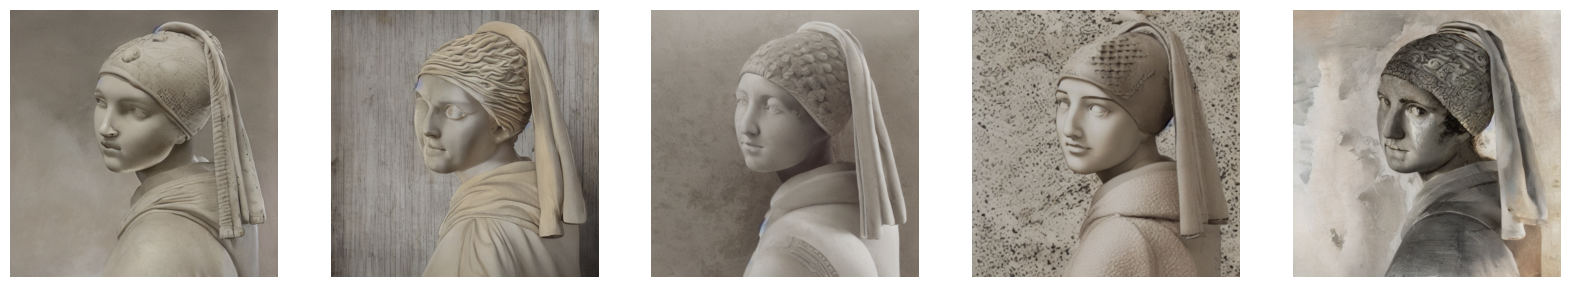

In [10]:
pipeline.set_ip_adapter_scale(1.0)
ip_image = load_image("statue.png").resize((256,256))
gen_images=[]

for _ in range(5):
    gen_image =     pipeline(
                            prompt="",
                            image=depth,
                            ip_adapter_image=ip_image,
                            guidance_scale=1,
                            num_inference_steps=50,
                            height=512,
                            width=512,
                        ).images[0]

    gen_images.append(gen_image)
    
plt.imshow(ip_image)
plt.title('image prompt')
plt.show()

fig,axes = plt.subplots(1,5,figsize=(20,20))
for i,ax in enumerate(axes):
    ax.imshow(gen_images[i])
    ax.axis('off')
plt.show()